In [1]:
import os
import numpy as np
import pandas as pd

from keras.preprocessing.image import load_img,img_to_array
from keras.applications.inception_v3 import preprocess_input, InceptionV3

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.linear_model import LogisticRegressionCV



Using TensorFlow backend.


In [2]:
os.chdir('G:\\Machine learning\\AV competition')
test_csv = pd.read_csv('test_ApKoW4T.csv')
train_csv = pd.read_csv('train\\train.csv')

In [6]:
# Reading images in specific dimensions and proeprocessing according to Inception_V3.

os.chdir('G:\\Machine learning\\AV competition\\train\\images')
path = os.getcwd()

train = []
test = []
for i in train_csv['image']:
    for j in os.listdir(path):
        
        if i == j:
            
            im1 = Image.open(os.path.join(path,i))
            im1 = im1.resize((210,140), Image.BILINEAR)
            
            if np.ndim(im1) == 2:
                im1 = np.stack((im1,)*3, axis=-1)                        # For images that are black and white.
#                 im1 = img_to_array(im1)
            im1 = np.expand_dims(im1,axis=0)                             # Expanding dimesions for preprocess_input format.
            im1 = preprocess_input(im1)
            
            if im1 is not None:
                train.append(im1[0])                                     #Expanded dimesion is removed by [0].
                
    
        
for i in test_csv['image']:
    for j in os.listdir(path):
        t = 0
        if i == j:
            
            im1 = Image.open(os.path.join(path,i))
            im1 = im1.resize((210,140), Image.BILINEAR)
            
            if np.ndim(im1) == 2:
                im1 = np.stack((im1,)*3, axis=-1)
#             im1 = img_to_array(im1)    
            im1 = np.expand_dims(im1,axis=0)
            im1 = preprocess_input(im1)
            
            if im1 is not None:
                test.append(im1[0])
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(140, 210, 3)

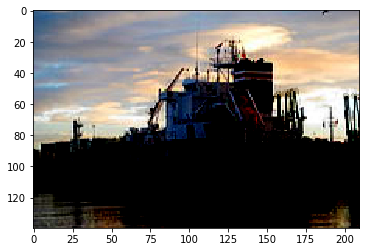

In [8]:
plt.imshow(train[50])
np.shape(test[100])

In [9]:
y=to_categorical(np.array(train_csv['category'] - 1),num_classes=5) 
# -1 because 'to_categorical' expects input to start from 0.

X_train, X_test, y_train, y_test = train_test_split(train,y,test_size=0.10, random_state=42, shuffle = True)

In [14]:
# Using Inception_V3 as feature extractor.

base_model=InceptionV3(weights='imagenet',include_top=False,input_shape=(140,210,3),pooling='avg')
features = base_model.predict(np.array(X_train))

In [20]:
np.shape(features)

(5626, 2048)

In [11]:
# Outputs category with maximum probability.

def out(a):
    yf = []
    for i in a.index:
        max = 0
        max_c = 0
        for j in a.columns:

            if (a.iloc[i][j] > max):

                max = a.iloc[i][j]
                max_c = j


        yf.append(max_c+1) 
    return yf    

In [17]:
# Logistic Regression on top of extracted features.

clf=LogisticRegressionCV(cv = 8)
yk = out(pd.DataFrame(y_train))
clf.fit(features,yk)
c = pd.DataFrame(clf.predict(np.array(features)))

In [25]:
# Working on test data.

features = base_model.predict(np.array(test))
ans = pd.DataFrame(clf.predict(np.array(features)))

In [26]:
# Generating output.

sub = pd.DataFrame({'image' : np.array(test_csv['image']), 'category' : np.array(ans[0])})
sub.to_csv('sub_inception_lr.csv',index = False)